## redes neuronales recurrentes /-/ series temporales

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
leche = pd.read_csv('/home/rayzo/Descargas/original(4).csv', index_col='Month')

In [61]:
leche.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [62]:
leche.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6+ KB


In [63]:
leche.index = pd.to_datetime(leche.index)

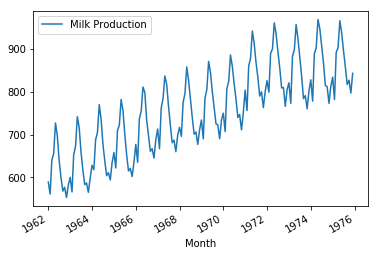

In [64]:
leche.plot()

In [5]:
conjuto_entrenamiento = leche.head(150)

In [6]:
conjunto_pruebas = leche.tail(18)

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
normalizacion = MinMaxScaler()

In [10]:
entrenamiento_normalizado = normalizacion.fit_transform(conjuto_entrenamiento)
pruebas_normalizado = normalizacion.transform(conjunto_pruebas)

In [11]:
def lotes(datos_entrenamiento, tamaño_lote, pasos):
    comienzo = np.random.randint(0, len(datos_entrenamiento) - pasos)
    lote_y = np.array(datos_entrenamiento[comienzo:comienzo+pasos+1]).reshape(1,pasos+1)
    return lote_y[:,:-1].reshape(-1,pasos,1), lote_y[:,1:].reshape(-1,pasos,1)

In [12]:
numero_entradas = 1
numero_pasos = 18
numero_neuronas = 120
numero_de_salidas = 1
tasa_aprendizaje = 0.001
numero_iteraciones_entrenamiento = 5000
tamaño_lote = 1

In [13]:
x = tf.placeholder(tf.float32, [None, numero_pasos, numero_entradas])
y = tf.placeholder(tf.float32, [None, numero_pasos, numero_de_salidas])

In [14]:
capa = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=numero_neuronas, activation=tf.nn.relu), output_size=numero_de_salidas)


In [15]:
salidas, estados = tf.nn.dynamic_rnn(capa, x, dtype=tf.float32)

In [16]:
funcion_error = tf.reduce_mean(tf.square(salidas-y))
optimizador = tf.train.AdamOptimizer(learning_rate=tasa_aprendizaje)
entrenamiento = optimizador.minimize(funcion_error)

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
with tf.Session() as sesion:
    sesion.run(init)
    for iteracion in range(numero_iteraciones_entrenamiento):
        lote_x, lote_y = lotes(entrenamiento_normalizado, tamaño_lote, numero_pasos)
        sesion.run(entrenamiento, feed_dict={x:lote_x, y:lote_y})
        if iteracion %100 == 0:
            error = funcion_error.eval(feed_dict={x:lote_x, y:lote_y})
            print(iteracion,'\t Error', error)
        saver.save(sesion, "./modelo_series_temporales")

0 	 Error 0.07264746
100 	 Error 0.024909973
200 	 Error 0.018365398
300 	 Error 0.01300688
400 	 Error 0.009772781
500 	 Error 0.007274992
600 	 Error 0.011823949
700 	 Error 0.007568698
800 	 Error 0.0058646733
900 	 Error 0.008025111
1000 	 Error 0.006330611
1100 	 Error 0.005215352
1200 	 Error 0.0061478605
1300 	 Error 0.004805642
1400 	 Error 0.0048352573
1500 	 Error 0.0060496274
1600 	 Error 0.006848581
1700 	 Error 0.009844304
1800 	 Error 0.0044573755
1900 	 Error 0.007923412
2000 	 Error 0.0030607674
2100 	 Error 0.00399557
2200 	 Error 0.0033762811
2300 	 Error 0.0031435315
2400 	 Error 0.003870888
2500 	 Error 0.005917899
2600 	 Error 0.003164963
2700 	 Error 0.005026197
2800 	 Error 0.006262375
2900 	 Error 0.0033766231
3000 	 Error 0.0033885664
3100 	 Error 0.005761317
3200 	 Error 0.0045341863
3300 	 Error 0.0017845146
3400 	 Error 0.0048643537
3500 	 Error 0.00397825
3600 	 Error 0.0019292318
3700 	 Error 0.002604654
3800 	 Error 0.0027057435
3900 	 Error 0.0033394461


In [26]:
with tf.Session() as sesion:
    saver.restore(sesion, './modelo_series_temporales')
    entrenamiento_seed = list(entrenamiento_normalizado[-18:])
    for iteracion in range(18):
        lote_x = np.array(entrenamiento_seed[-numero_pasos:]).reshape(1,numero_pasos,1)
        prediccion_y = sesion.run(salidas, feed_dict={x:lote_x})
        entrenamiento_seed.append(prediccion_y[0,-1,0])

INFO:tensorflow:Restoring parameters from ./modelo_series_temporales


In [28]:
resultados = normalizacion.inverse_transform(np.array(entrenamiento_seed[18:]).reshape(18,1))

In [29]:
resultados

array([[ 913.737  ],
       [ 891.32263],
       [ 858.84674],
       [ 857.6352 ],
       [ 837.32983],
       [ 856.6199 ],
       [ 880.9157 ],
       [ 877.6462 ],
       [ 950.1556 ],
       [ 980.19464],
       [1006.0891 ],
       [ 978.7492 ],
       [ 949.4764 ],
       [ 919.8877 ],
       [ 888.8248 ],
       [ 899.28546],
       [ 871.51196],
       [ 911.36194]], dtype=float32)

In [30]:
conjunto_pruebas['Predicciones'] = resultados

/home/rayzo/anaconda3/envs/pruebastensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
conjunto_pruebas

,Milk Production,Predicciones
Month,,
1974-07-01 01:00:00,908.0,913.737000
1974-08-01 01:00:00,867.0,891.322632
1974-09-01 01:00:00,815.0,858.846741
1974-10-01 01:00:00,812.0,857.635193
1974-11-01 01:00:00,773.0,837.329834
1974-12-01 01:00:00,813.0,856.619873
1975-01-01 01:00:00,834.0,880.915710
1975-02-01 01:00:00,782.0,877.646179
1975-03-01 01:00:00,892.0,950.155579


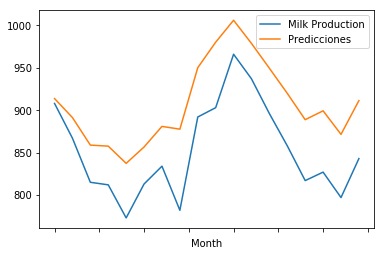

In [32]:
conjunto_pruebas.plot()